In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Concatenate
from IPython import display
from sklearn.model_selection import train_test_split
import glob
import imageio
from compas.datastructures import Mesh
from compas_plotters.meshplotter import MeshPlotter
import networkx 
from networkx.algorithms.components.connected import connected_components
from keras import layers, activations
import os
import pandas as pd
import tensorflow as tf
import random

c:\Users\31613\anaconda3\envs\thesiscopy\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


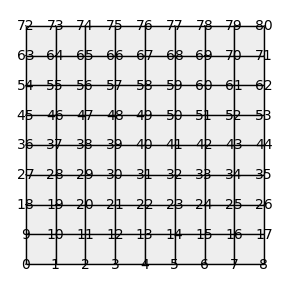

In [38]:
job_directory=os.getcwd()
data= os.path.join(job_directory, "Data","dense_meshquarter.obj")
meshdense = Mesh.from_obj(data)
plotter = MeshPlotter(meshdense, figsize=(3, 3))
plotter.draw_edges()
plotter.draw_vertices(text='key', radius=0.01)
plotter.draw_faces()
plotter.show()

In [49]:
#REL to adjacency matrix
def flatten_to_matrix(flatten_lst,shape1):
    array_zero=np.zeros((shape1,shape1))
    y=0
    for i in range(shape1):
        for e in range(i):
            array_zero[i,e]=flatten_lst[y]
            array_zero[e,i]=flatten_lst[y]
            y=y+1
    array_new=array_zero
    return array_new

In [40]:
# Get a mesh from an adjacency matrix
def Mesh_from_mtx(mtx):
    vertices_old = list(meshdense.vertices())
    v_old=[]
    for i in vertices_old:
        i_coordinates_old=Mesh.vertex_coordinates(meshdense, i, axes='xyz')
        v_old.append(i_coordinates_old)

    #get the connected edges
    D=networkx.DiGraph(mtx) 
    edges = [[u, v] for [u, v] in D.edges()]

    #sort the tuples of edges
    temp=[]
    for i in edges:
        temp.append(tuple(sorted(i)))

    #delete duplicate edges
    temp=set(temp) #first create ser

    temp=tuple(temp) #convert set to tuple

    #Convert to list
    edges=[]
    for i in temp:
        z=[]
        for y in i:
            z.append(v_old[y])
        edges.append(z)

    mrebuild=Mesh.from_lines(edges)
    return (mrebuild)

In [10]:
#Load dataset
Trainning_Dataset_dir= os.path.join(job_directory, "Trainning_Dataset")
feautures_flatten_dir=os.path.join(Trainning_Dataset_dir, "feautures_flatten.npy")
feautures_flatten_best_dir=os.path.join(Trainning_Dataset_dir, "feautures_flatten_best.npy")
labels_dir=os.path.join(Trainning_Dataset_dir, "labels.npy")
x_train_dir=os.path.join(Trainning_Dataset_dir, "x_train.npy")
y_train_dir=os.path.join(Trainning_Dataset_dir,"y_train.npy")
x_test_dir=os.path.join(Trainning_Dataset_dir, "x_test.npy")
y_test_dir=os.path.join(Trainning_Dataset_dir,"y_test.npy")

feautures=np.load(feautures_flatten_dir, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
feautures_best=np.load(feautures_flatten_best_dir, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
labels=np.load(labels_dir, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
x_train=np.load(x_train_dir, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
y_train=np.load(y_train_dir, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
x_test=np.load(x_test_dir, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
y_test=np.load(y_test_dir, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [11]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [17]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(3240))
x = layers.Dense(1000, activation="relu")(encoder_inputs)
#x = layers.Dense(1000, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3240)]       0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 1000)         3241000     ['input_3[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 100)          100100      ['dense_5[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 10)           1010        ['dense_6[0][0]']                
                                                                                            

In [18]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(100, activation="relu")(latent_inputs)
#x = layers.Dense(1000, activation="relu")(x)
x = layers.Dense(1000, activation="relu")(x)
decoder_outputs= layers.Dense(3240, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_7 (Dense)             (None, 100)               1100      
                                                                 
 dense_8 (Dense)             (None, 1000)              101000    
                                                                 
 dense_9 (Dense)             (None, 3240)              3243240   
                                                                 
Total params: 3,345,340
Trainable params: 3,345,340
Non-trainable params: 0
_________________________________________________________________


In [19]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder


    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            #reconstruction =tf.round(self.decoder(z))
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            reconstruction_loss *= 3240
           
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var) 
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5 

            total_loss = reconstruction_loss + kl_loss 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


    def test_step(self, data):
      if isinstance(data, tuple):
        data = data[0]

      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(
            keras.losses.mean_squared_error(data, reconstruction)
      )
      reconstruction_loss *= 81 * 81

      kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
      kl_loss = tf.reduce_mean(kl_loss)
      kl_loss *= -0.5
      total_loss = reconstruction_loss + kl_loss

      return {
          "loss": total_loss,
          "reconstruction_loss": reconstruction_loss,
          "kl_loss": kl_loss,
      }

In [ ]:
vae =VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
history = vae.fit(feautures, epochs=500, batch_size=64,validation_split=0.2)

In [ ]:
#plot random mesh
tf_random=tf.random.uniform(shape
    =[1, 10],
    minval=0.3,
    maxval=0.5,
    dtype=tf.dtypes.float32,
    seed=None,
    name=None
)
decodedtensor=vae.decoder(tf_random)[0]
decodedtensor=tf.round(decodedtensor)
decodesarray=decodedtensor.numpy()
mtx=flatten_to_matrix(decodesarray,81)
testmesh= Mesh_from_mtx(mtx)
plotter = MeshPlotter(testmesh, figsize=(2, 2))
plotter.draw_edges()
plotter.draw_vertices(text='key', radius=0.01)
plotter.draw_faces()
plotter.show()


In [ ]:
#Save the VAE
vae_save_dir= os.path.join(job_directory, "Saved_Models")
vae.get_layer('encoder').save_weights(os.path.join(vae_save_dir, "encoder_weights.h5"))
vae.get_layer('decoder').save_weights(os.path.join(vae_save_dir, "decoder_weights.h5"))
vae.get_layer('encoder').save(os.path.join(vae_save_dir, "encoder_arch"))
vae.get_layer('decoder').save(os.path.join(vae_save_dir, "decoder_arch"))

(3240,)


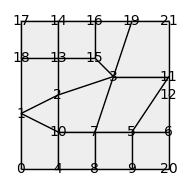

tf.Tensor(
[2.0101666e-04 9.8676133e-01 2.7391315e-04 ... 1.2900531e-03 8.3337486e-01
 3.2255054e-04], shape=(3240,), dtype=float32)


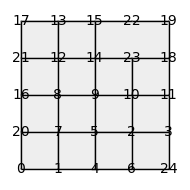

In [59]:
#plot a best design that is not included in the dataset
test_mesh=feautures_best[6]
print (test_mesh.shape)
mtx=flatten_to_matrix(test_mesh,81)
testmesh= Mesh_from_mtx(mtx)
plotter = MeshPlotter(testmesh, figsize=(2, 2))
plotter.draw_edges()
plotter.draw_vertices(text='key', radius=0.01)
plotter.draw_faces()
plotter.show()


#plot the decoded design 
x= vae.encoder(test_mesh.reshape(1,3240))
mean=x[0]
logvar=x[1]
z=x[2]
decodedtensor=vae.decoder(z)[0]
print (decodedtensor)
decodedtensor=tf.round(decodedtensor)
decodesarray=decodedtensor.numpy()
mtx=flatten_to_matrix(decodesarray,81)
testmesh= Mesh_from_mtx(mtx)
plotter = MeshPlotter(testmesh, figsize=(2, 2))
plotter.draw_edges()
plotter.draw_vertices(text='key', radius=0.01)
plotter.draw_faces()
plotter.show()
